In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import StandardScaler, maxabs_scale
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score,f1_score, roc_curve, auc, accuracy_score, confusion_matrix
import shutil
import seaborn as sns

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from model import MeronSmart, ml_models,plot_confusion_matrix

In [3]:
meron = MeronSmart()

In [40]:
regression_model = meron.build_model(neurons=[128,32],dropout=0.5,task_type='regression',n_hidden_layers=2)

In [17]:
regression_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               525056    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total para

In [18]:
merged_df = pd.read_csv('/data/meron/kenya_data/meron_merged_mal(sam_mam_upsampled)_muac.csv')
meta_data = pd.read_csv('/data/meron/kenya_data/meron_link_data/meron_meta_processed.csv')
sam_names=pd.read_csv('/data/meron/sam_photo_ids.csv')
mam_names=pd.read_csv('/data/meron/mam_photo_ids.csv')

#use wfh in meta_data to filter out the extreme outliers
merged_df=merged_df[(merged_df['wfh']<4) & (merged_df['wfh']> -4)]

In [92]:
merged_df.head()

,photo_id,0,1,2,3,4,5,6,7,8,...,2046,2047,gender_male,age_months,maln_mam,maln_normal,maln_sam,wfh,maln_class,muac_prediction
0,1517384891739.jpg,0.157335,0.015997,0.707683,0.009274,0.000000,0.698504,1.974866,6.329210,0.0,...,1.867832,0.024899,0,32.0,1,0,0,-2.97,mam,normal
1,1517384891739.jpg,0.000000,0.000000,1.571181,0.000000,0.000000,0.627390,1.353355,6.647170,0.0,...,2.161191,0.000000,0,32.0,1,0,0,-2.97,mam,normal
2,1517478268776.jpg,0.045922,0.000000,3.087823,0.000000,0.331306,1.069497,1.636940,1.760356,0.0,...,4.154829,0.812403,1,19.0,1,0,0,-2.09,mam,normal
3,1517478268776.jpg,0.181375,0.000000,3.747156,0.022242,1.065049,1.856126,1.670891,2.034269,0.0,...,3.283012,1.401969,1,19.0,1,0,0,-2.09,mam,normal
4,1517238175403.jpg,0.000000,0.369026,2.461378,2.946527,0.661946,4.072535,0.526728,6.682256,0.0,...,2.062518,0.352439,1,18.0,0,1,0,-1.16,normal,normal


# separate the sam samples so duplicates(flipped image) are not distributed evenly in training and test. samples in validation set are not seen in training

In [19]:
sam_samples=merged_df.loc[merged_df['photo_id'].isin(sam_names['photo_id'])]
mam_samples=merged_df.loc[merged_df['photo_id'].isin(mam_names['photo_id'])]

other_samples=merged_df.loc[~merged_df['photo_id'].isin(sam_names['photo_id'])].loc[~merged_df['photo_id'].isin(mam_names['photo_id'])]

In [8]:
print('sam sample size:{}'.format(sam_samples.shape))
print('mam sample size:{}'.format(mam_samples.shape))
print('other sample size:{}'.format(other_samples.shape))

sam sample size:(172, 2057)
mam sample size:(944, 2057)
other sample size:(3019, 2057)


In [20]:
sam_train=sam_samples[:137]
sam_validation=sam_samples[137:]
print('sam training size:{}'.format(sam_train.shape))
print('sam val size:{}'.format(sam_validation.shape))

sam training size:(137, 2057)
sam val size:(35, 2057)


In [21]:
mam_train=mam_samples[:750]
mam_validation=mam_samples[750:]
print('mam training size:{}'.format(mam_train.shape))
print('mam val size:{}'.format(mam_validation.shape))

mam training size:(750, 2057)
mam val size:(194, 2057)


In [22]:
## fetch target variable wfh
target_sam_train = np.array(sam_train['wfh'])
target_sam_validation=np.array(sam_validation['wfh'])

target_mam_train = np.array(mam_train['wfh'])
target_mam_validation=np.array(mam_validation['wfh'])

target_other=np.array(other_samples['wfh'])

In [23]:
deselect_cols = ['photo_id','maln_mam','maln_normal','maln_sam','wfh','maln_class', 'muac_prediction']

In [24]:
select = [x for x in merged_df.columns if x not in deselect_cols]
sam_train_features = sam_train.loc[:, select]
sam_validation_features = sam_validation.loc[:, select]

mam_train_features = mam_train.loc[:, select]
mam_validation_features = mam_validation.loc[:, select]

other_features=other_samples.loc[:, select]
other_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,gender_male,age_months
4,0.000000,0.369026,2.461378,2.946527,0.661946,4.072535,0.526728,6.682256,0.000000,0.0,...,0.687893,0.000000,0.000000,1.743518,0.575827,0.000000,2.062518,0.352439,1,18.0
9,6.018714,0.000000,4.922188,0.250943,3.632266,0.441533,2.783796,9.161777,0.000000,0.0,...,0.000000,0.000000,0.451506,3.653616,0.734750,0.000000,0.000000,0.000000,0,25.0
10,0.302067,0.000000,0.856374,4.006856,0.000000,0.476372,4.314477,11.858264,0.000000,0.0,...,1.534502,0.000000,0.453811,16.605633,0.000000,0.845772,0.506828,0.000000,1,40.0
11,0.000000,0.296940,4.927894,0.212098,0.008911,1.134834,3.333884,2.954910,1.047672,0.0,...,1.352508,0.005078,0.010983,8.271940,0.000000,0.000000,0.876071,0.032372,0,41.0
12,0.000000,0.228124,0.801086,0.476915,1.492239,1.457904,1.052291,18.379776,0.000000,0.0,...,0.005074,0.000000,0.000000,12.780549,0.740513,0.000000,1.912864,1.549561,0,28.0


# Split data into training and testing sets, then train model

In [25]:
whole_data=pd.concat([other_features, sam_train_features, sam_validation_features,mam_train_features,mam_validation_features], axis=0)

In [26]:
### scale/standardize the features? Don't need to standardize the target, it's a z-score
conv_scaler = StandardScaler().fit(whole_data)
sam_train_features_scaled = conv_scaler.transform(sam_train_features)
sam_validation_features_scaled=conv_scaler.transform(sam_validation_features)

mam_train_features_scaled = conv_scaler.transform(mam_train_features)
mam_validation_features_scaled=conv_scaler.transform(mam_validation_features)

other_features_scaled=conv_scaler.transform(other_features)

In [27]:
### Break data into training and test (stratified)
X_train1, X_test1, y_train1, y_test1 = train_test_split(other_features_scaled, target_other, test_size=0.2, 
                                                        random_state=42)

X_train=np.concatenate((X_train1,sam_train_features_scaled,mam_train_features_scaled), axis=0)
y_train=np.concatenate((y_train1,target_sam_train,target_mam_train), axis=0)

X_test=np.concatenate((X_test1,sam_validation_features_scaled,mam_validation_features_scaled), axis=0)
y_test=np.concatenate((y_test1,target_sam_validation, target_mam_validation), axis=0)

In [23]:
print(X_train.shape)
print(X_test.shape)

(3353, 2050)
(838, 2050)


In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('regression_model_resnetfeats_128_32(dropout05_upsampled2x)_leakyrelu.h5', monitor='val_loss', verbose=1,
                             save_best_only=True,save_weights_only=False, mode='min')

In [42]:
regression_model.fit(X_train,
                y_train,
                epochs=1000,
                batch_size=512,
                callbacks=[checkpoint, early_stop],
                shuffle=True,
                validation_data=(X_test, y_test),
                verbose=1)

Train on 3302 samples, validate on 833 samples
Epoch 1/1000
3302/3302 [==============================] - 1s 233us/step - loss: 7.7923 - acc: 6.0569e-04 - val_loss: 3.3519 - val_acc: 0.0024

Epoch 00001: val_loss improved from inf to 3.35193, saving model to regression_model_resnetfeats_128_32(dropout05_upsampled2x)_leakyrelu.h5
Epoch 2/1000
3302/3302 [==============================] - 0s 49us/step - loss: 5.7854 - acc: 0.0015 - val_loss: 2.4470 - val_acc: 0.0024

Epoch 00002: val_loss improved from 3.35193 to 2.44699, saving model to regression_model_resnetfeats_128_32(dropout05_upsampled2x)_leakyrelu.h5
Epoch 3/1000
3302/3302 [==============================] - 0s 46us/step - loss: 5.1853 - acc: 9.0854e-04 - val_loss: 2.1136 - val_acc: 0.0012

Epoch 00003: val_loss improved from 2.44699 to 2.11361, saving model to regression_model_resnetfeats_128_32(dropout05_upsampled2x)_leakyrelu.h5
Epoch 4/1000
3302/3302 [==============================] - 0s 46us/step - loss: 4.6380 - acc: 6.0569e-0

Epoch 30/1000
3302/3302 [==============================] - 0s 45us/step - loss: 2.0265 - acc: 0.0012 - val_loss: 1.5645 - val_acc: 0.0012

Epoch 00030: val_loss did not improve from 1.55976
Epoch 31/1000
3302/3302 [==============================] - 0s 50us/step - loss: 2.0280 - acc: 9.0854e-04 - val_loss: 1.5651 - val_acc: 0.0012

Epoch 00031: val_loss did not improve from 1.55976
Epoch 32/1000
3302/3302 [==============================] - 0s 60us/step - loss: 2.0117 - acc: 6.0569e-04 - val_loss: 1.5650 - val_acc: 0.0012

Epoch 00032: val_loss did not improve from 1.55976
Epoch 33/1000
3302/3302 [==============================] - 0s 55us/step - loss: 1.9467 - acc: 0.0012 - val_loss: 1.5678 - val_acc: 0.0012

Epoch 00033: val_loss did not improve from 1.55976
Epoch 34/1000
3302/3302 [==============================] - 0s 51us/step - loss: 1.9161 - acc: 0.0015 - val_loss: 1.5652 - val_acc: 0.0012

Epoch 00034: val_loss did not improve from 1.55976


# look at prediction vs actual values

In [35]:
model2=load_model('regression_model_resnetfeats_128_32(dropout05_upsampled2x)_leakyrelu.h5')
prediction=model2.predict(X_test, verbose=1)

833/833 [==============================] - 0s 190us/step


In [36]:
### optional, save prediction,  and wfh target
eval_df=pd.DataFrame({'wfh_prediction':prediction.flatten(), 'y_test_val':y_test.flatten()})
eval_df.head()

,wfh_prediction,y_test_val
0,-2.144780,-0.34
1,-1.431125,-1.27
2,-0.656834,-0.64
3,-0.858962,-1.65
4,-0.699172,-1.14


In [37]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0]**2 

r2(eval_df['y_test_val'], eval_df['wfh_prediction'])

0.10189353244532774

In [38]:
np.sqrt(r2(eval_df['y_test_val'], eval_df['wfh_prediction']))

0.31920766351284197

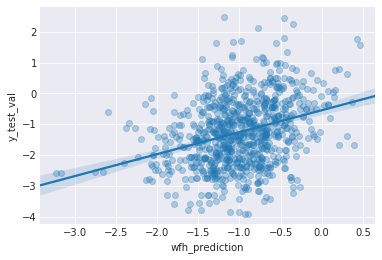

In [39]:
sns.set_style("darkgrid")
sns.regplot(x='wfh_prediction', y='y_test_val',data=eval_df, scatter_kws={'alpha':0.3})